# Deep Convolutional Generative Adversarial Networks (DCGAN)
## Import libraries

In [32]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
# import torch libraries 
import torch
from torch import optim
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.animation as animation
from torch.utils.tensorboard import SummaryWriter
from IPython.display import HTML

In [2]:
# Set random seed for reproducibility
manualSeed = 99
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  99


In [3]:
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')

## Load the data and preprocess the data  

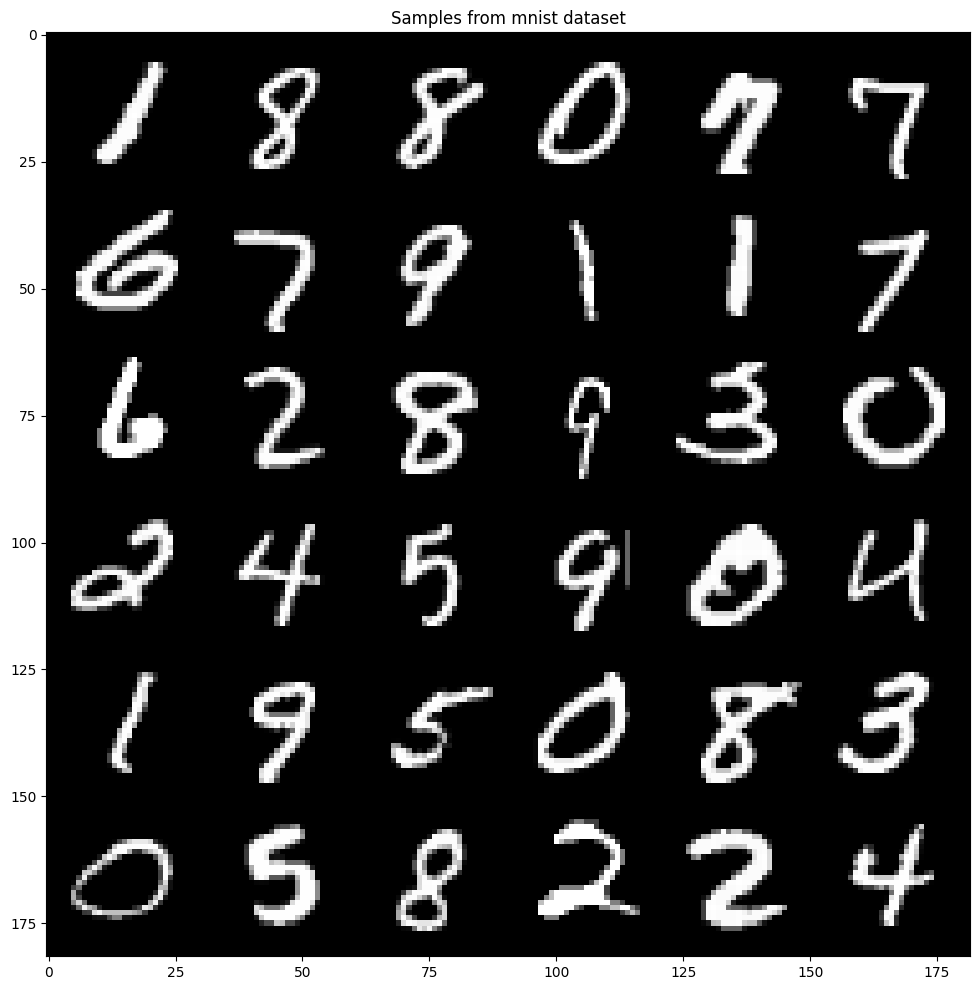

Size of the image is 28


In [4]:
batch_size = 128

# Do the transformation to the image dataset 
# mean = 0.5 and std = 0.5 then the (0 - 0.5)/0.5 become -1 and (1 - 0.5)/0.5
# image = (image - mean) / std 
# use of transforms.Normalize((.5,), (.5,)) ((mean_1_channel, mean_2_channel,), (std_1_channel, std_2_channel,)) like this 
Transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the dataset from the tensorflow dataset
mnist_dataset = datasets.MNIST(root=DATA_DIR_PATH, train=True, download=True, transform=Transfrom)

# Make the dataloader from the dataset 
mnist_data_loader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

num_imgs_to_visualize = 36
batch = next(iter(mnist_data_loader))
img_batch = batch[0]
img_batch_subset = img_batch[:num_imgs_to_visualize]

# Visualize the grid using the torchvision.utils make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)),) img_batch_subset [N,C,H,W]
grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True)
grid = np.moveaxis(grid.numpy(), 0, 2)
plt.figure(figsize=(12,12))
plt.title("Samples from mnist dataset")
plt.imshow(grid)
plt.show()

# Get the size of an image 
img_size_obj = img_batch_subset[0].size()
print("Size of the image is", img_size_obj[2])

In [5]:
# Custom weights initialization function 
# This function get the layer and check for the class name and initialize weights according to that class name
# Find method find substring of given name type fro example Conv match with the Conv2d ConvTranspose2d
# If it does not match with any thing return -1 otherwise the index of the first occurrence 
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define the Generator and Discriminator models 

In [34]:
# size of the generator input vector then the generator will 
nz = 100
# learning rate for the optimizers
lr = 0.0002
# beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# batch size during training
batch_size = 128
# size of the image 
img_size = 28
# number of channels in training image 
nc = 1
# number of epochs to train the network
num_epochs = 5
# number of feature maps
ngf = 64
# number of gpu available
ngpu = 1

# check whether a gpu is available and change the type to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# define the Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is z into the transpose convolution
            # shape is batch_size x 100(num_channel) x 1 x 1 [Batch,Channels,H,W]
            nn.ConvTranspose2d( nz, ngf*4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # size of the output is (ngf*4) x 4 x 4
            
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # size of the output is (ngf*2) x 8 x 8
            
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # size of the output is (ngf) x 16 x 16
            
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=3, bias=False),
            nn.Tanh()
            
            # size of the output is (nc) x 28 x 28
        )
        
    def forward(self, input):
        return self.main(input)

In [8]:
# create generator object and see the details
netG = Generator(ngpu).to(device)

# apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [9]:
# define the Discriminator 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is batch_size x 1 (num_channels) x 28 x 28
            nn.Conv2d(nc, ngf,kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # size of the output is (ngf) x 14 x 14
            
            nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # size of the output is (ngf*2) x 8 x 8
            
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # size of the output is (ngf*4) x 4 x 4
            nn.Conv2d(ngf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)

In [10]:
# create discriminator model
netD = Discriminator(ngpu).to(device)

# apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02
netD.apply(weights_init)

# print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


## Create the loss function and initialize the optimizers

In [11]:
# Initialize the loss function BCELoss function 
criterion = nn.BCELoss()

# create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# get real as 1 and fake as 0
real_label = 1
fake_label = 0

# setup the adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Create training loop for training the GAN

### Train the Discriminator
First, we will construct a batch of real samples from the training set, forward pass through Discriminator, calculate the loss

Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through Discriminator

### Train the Generator
We will construct a batch of fake samples with the current generator, forward pass this batch through Discriminator and Label as Real images and update the parameters of generator

In [19]:
data, label = next(iter(mnist_data_loader))
data = data.to(device)
result = netD(data)
print(result.shape)

torch.Size([128, 1, 1, 1])


In [ ]:
# training loop
# keep track of the losses 
img_list = []
G_losses = []
D_losses = []
iters = 0

print("training is starting ...")
for epoch in range(num_epochs):
    for i, data in enumerate(mnist_data_loader, 0):
        # 1. Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        # train with real batch
        # zero the accumulative gradients
        netD.zero_grad()
        # transfer the batch to the cpu
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        # label as real images with the size of  (label = [1, 1, 1, 1...])
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # forward pass through the discriminator 
        output = netD(real_img).view(-1)
        # calculate the error of the real images 
        errD_real = criterion(output, label)
        # calculate the gradients
        errD_real.backward()
        D_x = output.mean().item()
        
        # train the D with fake batch
        # generate a batch with latent vector
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # generate fake images with G
        fake = netG(noise)
        label.fill_(fake_label)
        # detach the generator from the discriminator to update the parameters only the discriminator
        output = netD(fake.detach()).view(-1)
        # calculate the fake label loss and derivatives
        errD_fake = criterion(output, label)
        # calculate the gradients, accumulated with previous
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # compute teh error od D as sum over the fake and real batches
        errD = errD_real + errD_fake
        # update the discriminator
        optimizerD.step()
        
        # 2. Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        # perform forward pass on all fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(mnist_data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(mnist_data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

training is starting ...
[0/5][0/468]	Loss_D: 0.0656	Loss_G: 5.5873	D(x): 0.9886	D(G(z)): 0.0441 / 0.0303
[0/5][50/468]	Loss_D: 0.0813	Loss_G: 6.6618	D(x): 0.9636	D(G(z)): 0.0245 / 0.0195
[0/5][100/468]	Loss_D: 0.3555	Loss_G: 7.7668	D(x): 0.9927	D(G(z)): 0.2088 / 0.0032
[0/5][150/468]	Loss_D: 0.1371	Loss_G: 5.8018	D(x): 0.9272	D(G(z)): 0.0167 / 0.0270
[0/5][200/468]	Loss_D: 0.0523	Loss_G: 6.2582	D(x): 0.9886	D(G(z)): 0.0346 / 0.0142
[0/5][250/468]	Loss_D: 0.0544	Loss_G: 5.5525	D(x): 0.9876	D(G(z)): 0.0362 / 0.0184
[0/5][300/468]	Loss_D: 0.1050	Loss_G: 5.9448	D(x): 0.9355	D(G(z)): 0.0081 / 0.0177
[0/5][350/468]	Loss_D: 0.0943	Loss_G: 5.0043	D(x): 0.9764	D(G(z)): 0.0559 / 0.0349
[0/5][400/468]	Loss_D: 0.1625	Loss_G: 5.5268	D(x): 0.9807	D(G(z)): 0.0892 / 0.0294
[0/5][450/468]	Loss_D: 0.0383	Loss_G: 5.5236	D(x): 0.9841	D(G(z)): 0.0197 / 0.0191
[1/5][0/468]	Loss_D: 0.7972	Loss_G: 10.3155	D(x): 0.9989	D(G(z)): 0.3689 / 0.0006
[1/5][50/468]	Loss_D: 0.0566	Loss_G: 6.3728	D(x): 0.9829	D(G(z)): 

## Plot the losses while training the Discriminator and Generator

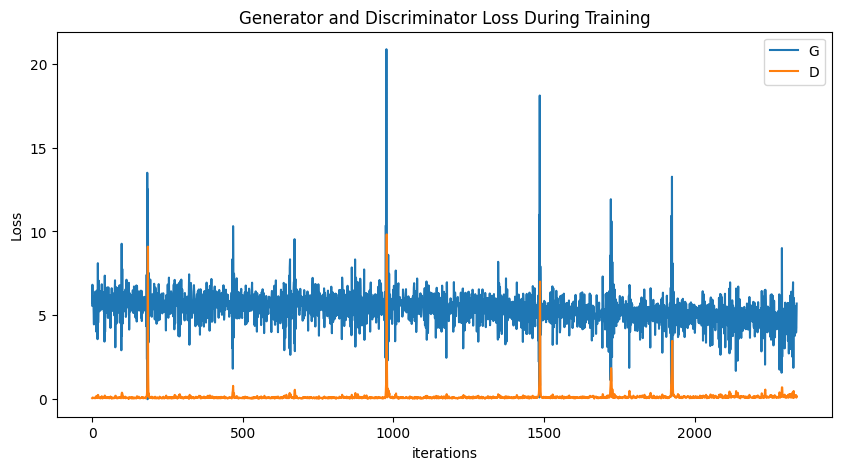

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

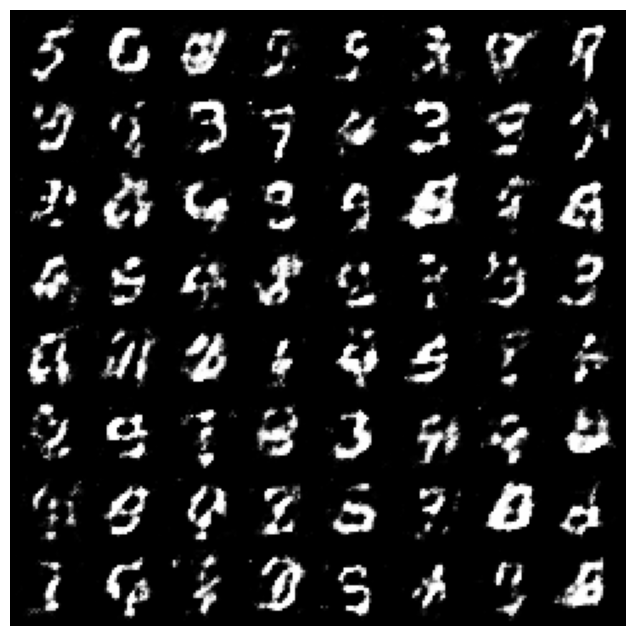

In [37]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

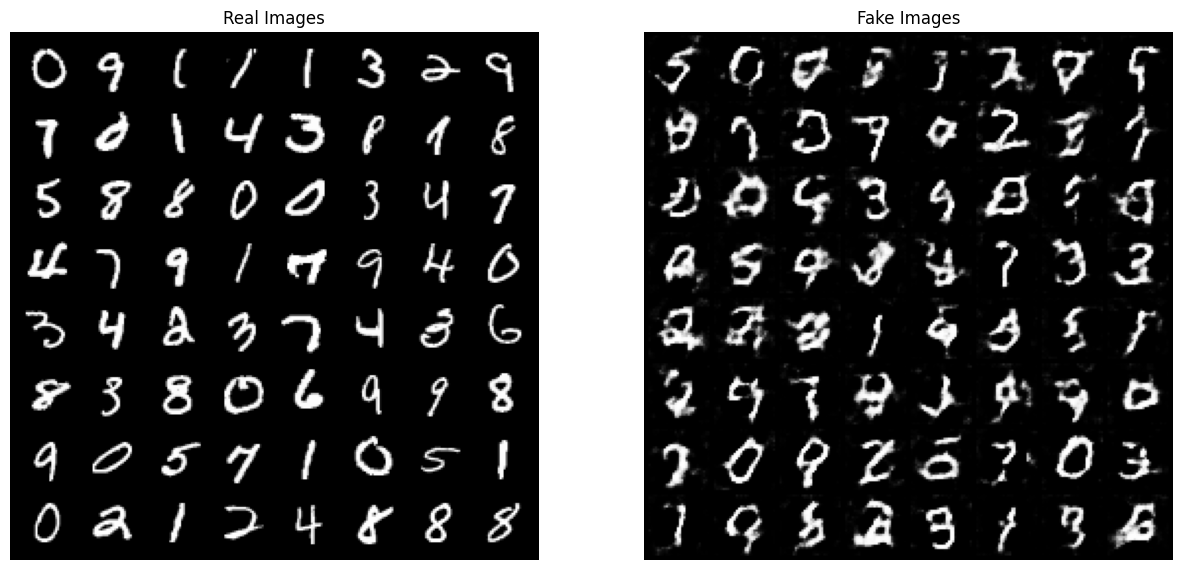

In [ ]:
# from pytorch documentation about GANs 
# Grab a batch of real images from the dataloader
real_batch = next(iter(mnist_data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()